In [1]:
#import required libraries

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import imageio

import random
from skimage import transform
from torchvision import transforms
import torch
from sklearn.model_selection import train_test_split

from preprocess.train import *
from preprocess.test import *
from plots.plots import *
from model.Unet import *
from model.LossFunction import *
from model.IoU_Score import *
from model.trainModel import *
from model.prediction import *

from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from torchvision.transforms import ToTensor

## Part 1: Getting the Data
- Download the LiveCell dataset from the provided source which is: https://mega.nz/folder/G9hT3SRY#He6hD4SiU3g1bMFxgsbTDw
- Extract the dataset to a local directory.
- Explore the dataset to understand its structure and content.
- Check the format of input images, segmentations, and loss weightings.
- Load the input images and segmentations into Python using appropriate libraries (e.g., PIL, OpenCV, or imageio).

In [2]:
# Define the paths to the train folder and its subfolders
train_folder = "unet_data/train"
image_folder = os.path.join(train_folder, "image")
label_folder = os.path.join(train_folder, "label")
border_folder = os.path.join(train_folder, "border")

In [3]:
# Get the list of image files in the image folder
image_files = os.listdir(image_folder)

# Load and explore the first image in the image folder
first_image_path = os.path.join(image_folder, image_files[0])
first_image = Image.open(first_image_path)

# Use review funtion from "preprocess/train" to review image features
review(first_image, image_files, "Image")

First Image File Name: A_1,1_ch00.tif
Image Format: TIFF
Image Mode: I;16
Image Size: (1024, 1024)


In [4]:
# Get the list of label files in the image folder
label_files = os.listdir(label_folder)

# Load and explore the first label in the label folder
first_label_path = os.path.join(label_folder, label_files[0])
first_label = Image.open(first_label_path)

# Use review funtion from "preprocess/train" to review label features
review(first_label, label_files, "Label")

First Label File Name: A_1,1_ch00.tif
Label Format: TIFF
Label Mode: F
Label Size: (1024, 1024)


In [5]:
# Get the list of border files in the image folder
border_files = os.listdir(border_folder)

# Load and explore the first border in the border folder
first_border_path = os.path.join(border_folder, border_files[0])
first_border = Image.open(first_border_path)

# Use review funtion from "preprocess/train" to review border features
review(first_border, border_files, "Border")

First Border File Name: A_1,1_ch00.tif
Border Format: TIFF
Border Mode: F
Border Size: (1024, 1024)


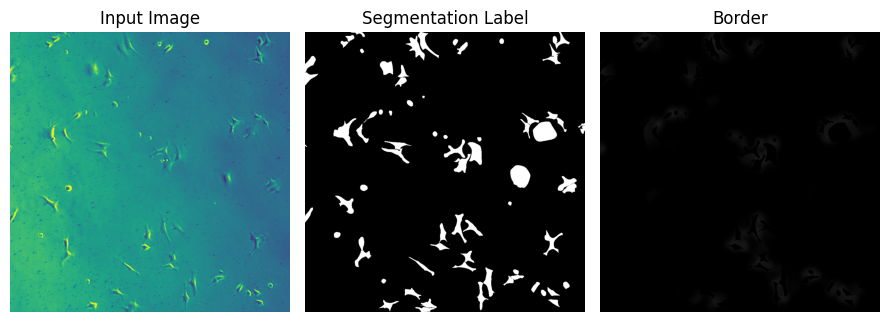

In [6]:
# Use plotAll funtion from "plots/plots" to visualize first image, label and border. Then save it to figures folder
plotAll(first_image, first_label, first_border, save_path="figures")

## Part 2: Data Preparation
- Load the input images and labels (segmentations) into Jupyter lab environment
- Preprocess the images and segmentations (e.g., resizing, normalization, etc.).
- Implement data augmentation techniques to increase the size and diversity of the dataset. 
- Augmentations include random rotations, flips, zooms, etc.
- Split the dataset into training and validation sets.

In [7]:
# Check the shapes of the first image and label
first_image = np.array(first_image)
print(first_image.shape)
first_label = np.array(first_label)
print(first_label.shape)

(1024, 1024)
(1024, 1024)


In [8]:
# Define the paths to the train folder and its subfolders
train_folder = "unet_data/train"
image_folder = os.path.join(train_folder, "image")
label_folder = os.path.join(train_folder, "label")

# Load images and labels from defined paths with using preprocess_train_data function from "preprocess/train"
# Then make first preprocess with resizing, turning numpy arrays
images, labels = preprocess_train_data(image_folder, label_folder)

In [9]:
print(images.shape)
print(labels.shape)
print(images[0].shape)
print(labels[0].shape)

(3, 256, 256)
(3, 256, 256)
(256, 256)
(256, 256)


In [10]:
# Check images and labels' min and max values and data types
check_data(images, labels)

Data Range:
Images Min: 8114 Max: 65535
Labels Min: -29.576769 Max: 287.46597

Data Types:
Images Type: uint16
Labels Type: float32


In [11]:
# Do second preprocess:
# Make the images normalized to the range [0, 1].
# Make the images are in float32 data type, and the labels are integers within a suitable range.
# Convert labels to binary format (0 for background, 1 for live cells)
images, labels = preprocess_data(images, labels)

In [12]:
# Check again after preprocess
check_data(images, labels)

Data Range:
Images Min: 0.12381171 Max: 1.0
Labels Min: 0 Max: 1

Data Types:
Images Type: float32
Labels Type: int32


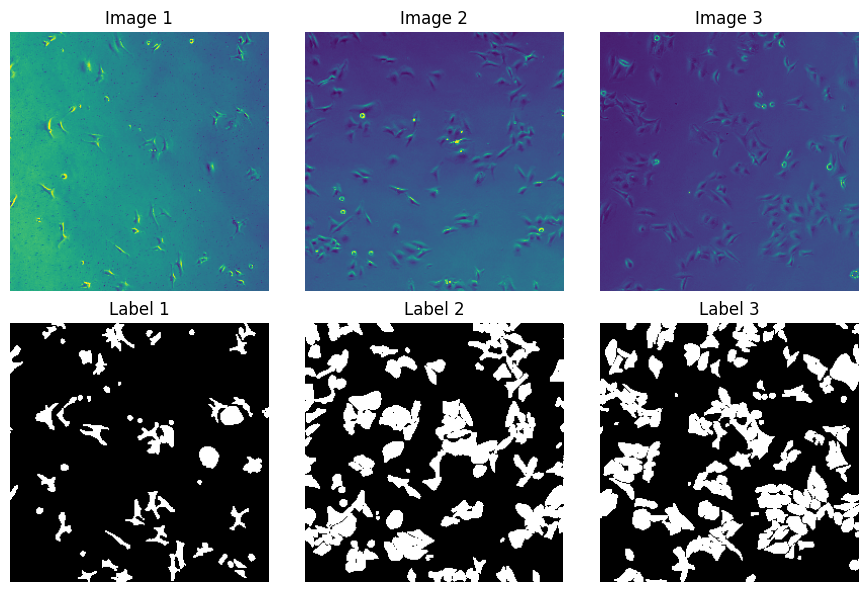

In [13]:
# Plot images and labels after preprocess, then save to "figures" folder
num_to_display = 3  # Number of images and labels to display
plotImageLabel(images, labels, num_to_display, save_path="figures")

In [14]:
# Apply aggressive augmentation to images and labels
# Check the data_augmentation function from "preprocess/train" file to see which methods are used
# The num_augmented_samples variable can be used to decide how many times an image will enter the increment cycle
num_augmented_samples = 100
target_size = (256, 256)
augmented_data = data_augmentation(images, labels, num_augmented_samples, target_size=target_size)

# Convert augmented data to numpy arrays with the appropriate data types
augmented_images = np.array([data[0] for data in augmented_data], dtype=np.float32)
augmented_labels = np.array([data[1] for data in augmented_data], dtype=np.int32)

print(len(augmented_images))  # Significantly increased compared to the original number of images
print(len(augmented_labels))  # Same as the number of augmented images

1773
1773


In [15]:
# Directory to save the augmented data
base_directory = "unet_data/train"
images_directory = os.path.join(base_directory, "augmented_images")
labels_directory = os.path.join(base_directory, "augmented_labels")

# Create the save directories if they don't exist
os.makedirs(images_directory, exist_ok=True)
os.makedirs(labels_directory, exist_ok=True)

# Save augmented images and labels as TIFF files
for i, (image, label) in enumerate(augmented_data):
    image_path = os.path.join(images_directory, f"augmented_image_{i}.tif")
    label_path = os.path.join(labels_directory, f"augmented_label_{i}.tif")
    
    imageio.imwrite(image_path, image.astype(np.uint16))
    imageio.imwrite(label_path, label.astype(np.float32))

print("Augmented data saved as TIFF files successfully.")

Augmented data saved as TIFF files successfully.


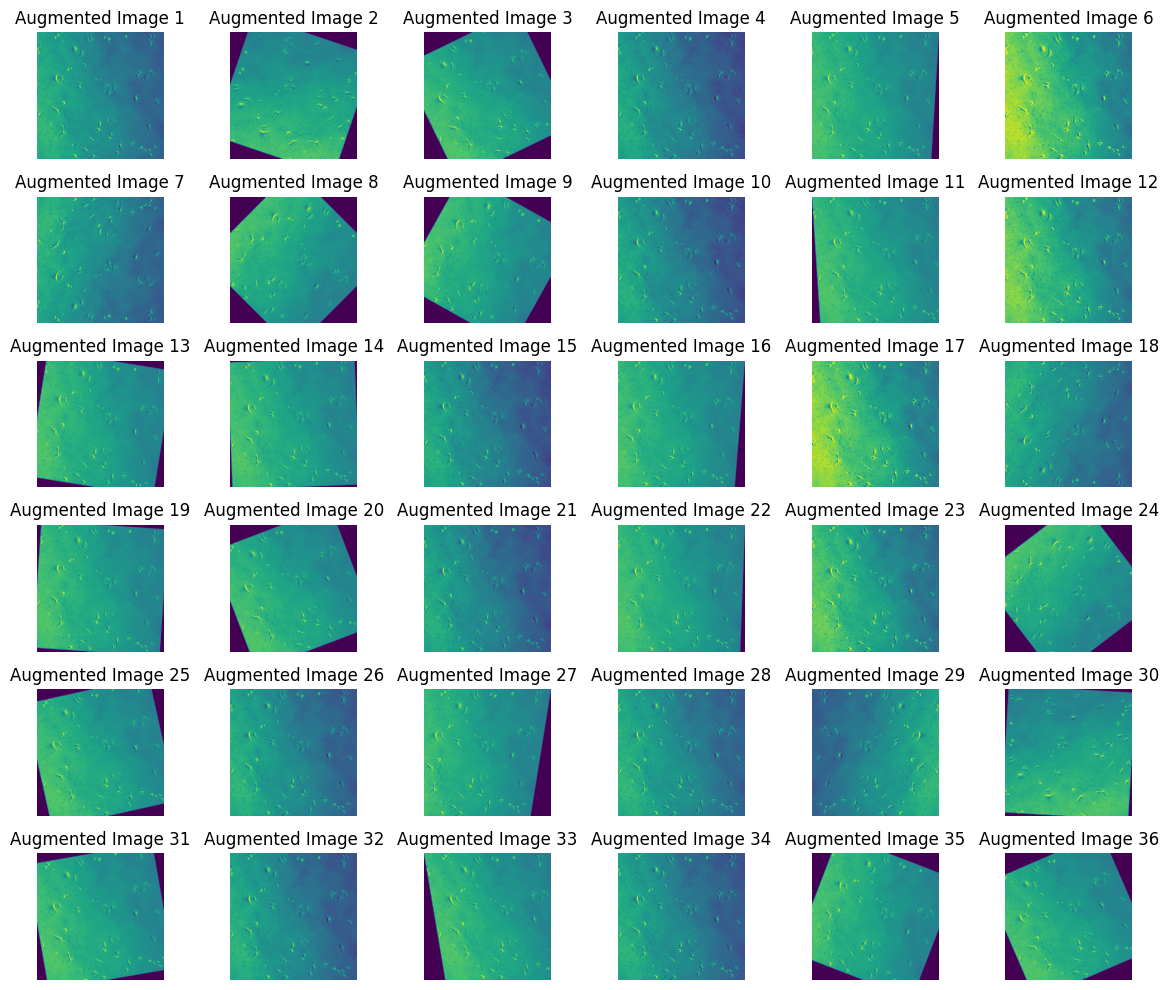

In [16]:
# Define the number of rows and columns for the grid
num_rows = 6
num_cols = 6

# Prepare the images and titles for plotting
images_to_plot = augmented_images[:num_rows*num_cols]
titles_to_plot = ['Augmented Image {}'.format(i+1) for i in range(num_rows*num_cols)]

# Display the grid of the first num_rows * num_cols augmented images
plot_image_grid(images_to_plot, titles_to_plot, num_rows, num_cols, plot_name = "inline", save_path="figures")

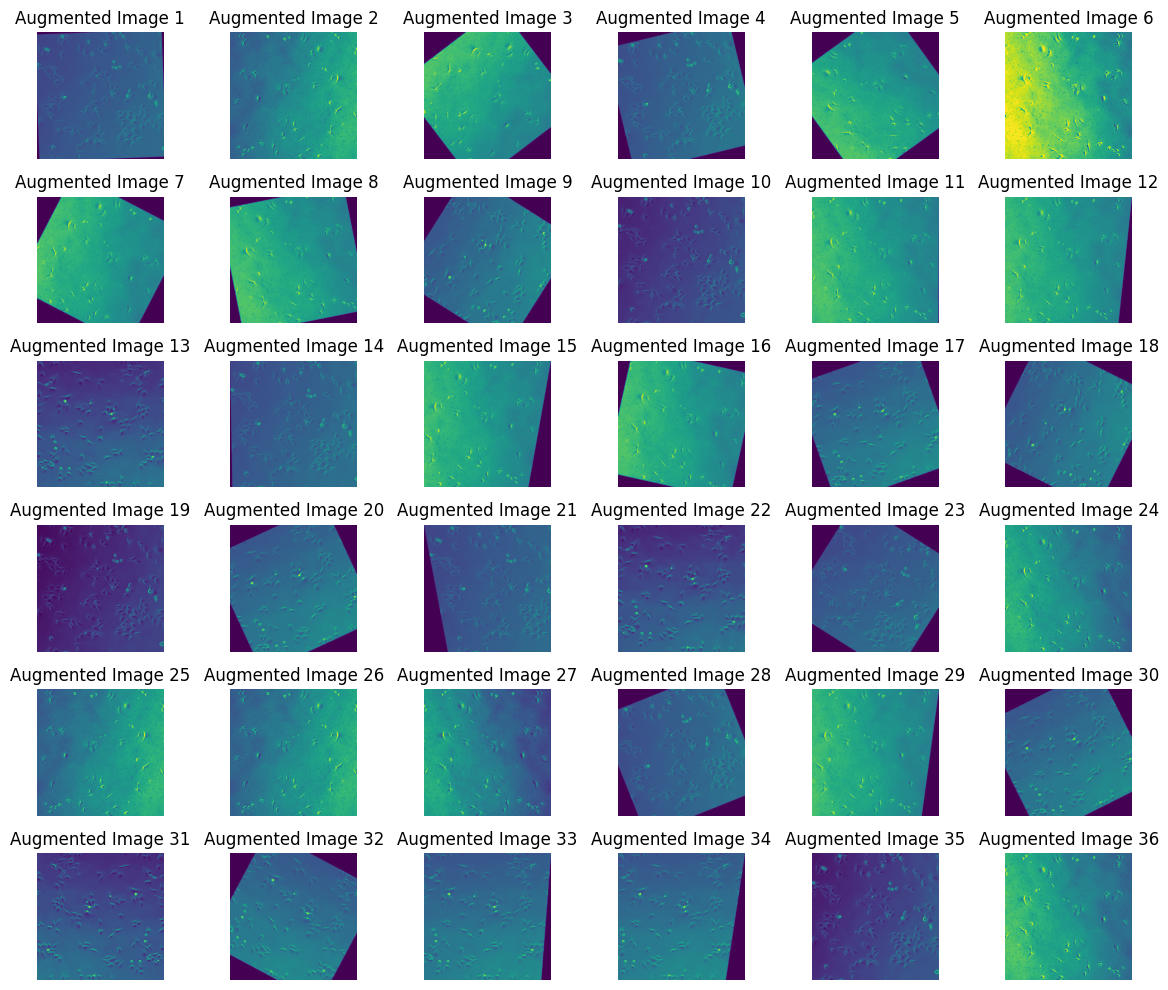

In [17]:
# Define the number of rows and columns for the grid
num_rows = 6
num_cols = 6

# Select random images from the augmented data
random_indices = np.random.randint(0, len(augmented_images), size=num_rows*num_cols)

# Prepare the images and titles for plotting
images_to_plot = augmented_images[random_indices]
titles_to_plot = ['Augmented Image {}'.format(i+1) for i in range(num_rows*num_cols)]

# Display the grid of random augmented images
plot_image_grid(images_to_plot, titles_to_plot, num_rows, num_cols, plot_name = "random", save_path="figures")

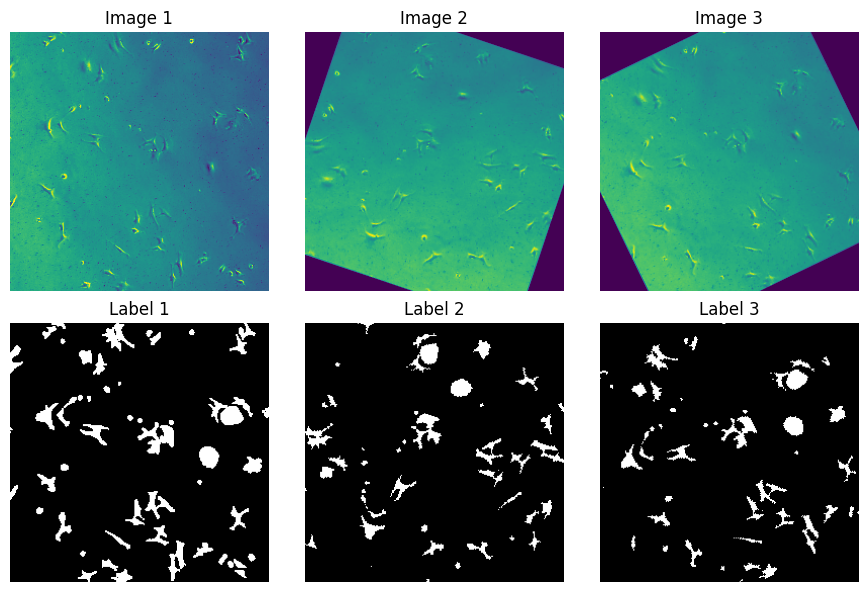

In [18]:
# Display the first few augmented images and labels
num_to_display = 3  # Number of images to display
plotImageLabel(augmented_images, augmented_labels, num_to_display, plot_name="augmented_plot", save_path="figures")

In [19]:
# Print the shapes of the augmented images and labels
print("Augmented Images Shape:", augmented_images.shape)
print("First Augmented Image Shape:", augmented_images[0].shape)
print("Augmented Labels Shape:", augmented_labels.shape)
print("First Augmented Label Shape:", augmented_labels[0].shape)

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(augmented_images, augmented_labels, test_size=0.15, random_state=42)

# Print the shapes of the training and validation sets
print("Training Images Shape:", train_images.shape)
print("First Training Image Shape:", train_images[0].shape)
print("Fourth Training Image Shape:", train_images[4].shape)
print("Training Labels Shape:", train_labels.shape)
print("First Training Label Shape:", train_labels[0].shape)
print("Validation Images Shape:", val_images.shape)
print("First Validation Image Shape:", val_images[0].shape)
print("Validation Labels Shape:", val_labels.shape)
print("First Validation Label Shape:", val_labels[0].shape)

Augmented Images Shape: (1773, 256, 256)
First Augmented Image Shape: (256, 256)
Augmented Labels Shape: (1773, 256, 256)
First Augmented Label Shape: (256, 256)
Training Images Shape: (1507, 256, 256)
First Training Image Shape: (256, 256)
Fourth Training Image Shape: (256, 256)
Training Labels Shape: (1507, 256, 256)
First Training Label Shape: (256, 256)
Validation Images Shape: (266, 256, 256)
First Validation Image Shape: (256, 256)
Validation Labels Shape: (266, 256, 256)
First Validation Label Shape: (256, 256)


## Part 3: Building the U-Net Model
- Define the architecture of the U-Net model, including the encoder and decoder parts.
- Decide on the loss function to be used for segmentation (BCELossWithLogits) and set up the loss-weightings
- Configure any regularization techniques (e.g., dropout, batch normalization) to prevent overfitting.
- Choose an appropriate optimizer (e.g., Adam) and set hyperparameters like learning rate and batch size.

**Check Model architecture on "model/Unet" and loss function on "model/LossFunction"**


In [20]:
# Check parameter number of model
model = UNet(num_classes=1)
num_params = count_parameters(model)
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 28256129


## Part 4: Training the U-Net Model
- Write a training loop to iteratively train the model on the training set.
- Implement mini-batch gradient descent to efficiently update the model weights.
- Monitor the training progress and validate the model on the validation set to avoid overfitting.
- Evaluate the model's performance using appropriate metrics such as Dice coefficient or Intersection over Union (IoU).
- Save the trained model and its weights for future use.

In [21]:
# Decide batch size according to your memory
batch_size = 16

# Convert numpy arrays to PyTorch tensors with the correct data type
train_images_tensor = torch.stack([ToTensor()(image.copy()) for image in train_images])
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_images_tensor = torch.stack([ToTensor()(image.copy()) for image in val_images])
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
# Decide learning rate and epochs numbers
learning_rate = 0.001
num_epochs = 10

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the number of classes based on your dataset
num_classes = 1

# Create an instance of the U-Net model with the correct number of classes
model = UNet(num_classes=num_classes).to(device)

# Define the loss function (binary cross-entropy) and optimizer (Adam)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

# Train the model
model, train_losses, train_ious, train_accuracies, val_losses, val_ious, val_accuracies = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, device=device)

Epoch [1/10] Train Loss: 0.3806 Train IoU: 0.3422 Train Accuracy: 0.8346 Val Loss: 0.2883 Val IoU: 0.4563 Val Accuracy: 0.8728
Epoch [2/10] Train Loss: 0.2512 Train IoU: 0.4953 Train Accuracy: 0.8895 Val Loss: 0.2438 Val IoU: 0.4684 Val Accuracy: 0.8883
Epoch [3/10] Train Loss: 0.2069 Train IoU: 0.5581 Train Accuracy: 0.9094 Val Loss: 0.1929 Val IoU: 0.5811 Val Accuracy: 0.9140
Epoch [4/10] Train Loss: 0.1764 Train IoU: 0.6139 Train Accuracy: 0.9237 Val Loss: 0.1801 Val IoU: 0.5536 Val Accuracy: 0.9198
Epoch [5/10] Train Loss: 0.1567 Train IoU: 0.6500 Train Accuracy: 0.9326 Val Loss: 0.1488 Val IoU: 0.6193 Val Accuracy: 0.9350
Epoch [6/10] Train Loss: 0.1333 Train IoU: 0.6957 Train Accuracy: 0.9438 Val Loss: 0.1202 Val IoU: 0.7194 Val Accuracy: 0.9482
Epoch [7/10] Train Loss: 0.1227 Train IoU: 0.7147 Train Accuracy: 0.9481 Val Loss: 0.1312 Val IoU: 0.7067 Val Accuracy: 0.9429
Epoch [8/10] Train Loss: 0.1170 Train IoU: 0.7267 Train Accuracy: 0.9505 Val Loss: 0.1392 Val IoU: 0.6917 Val A

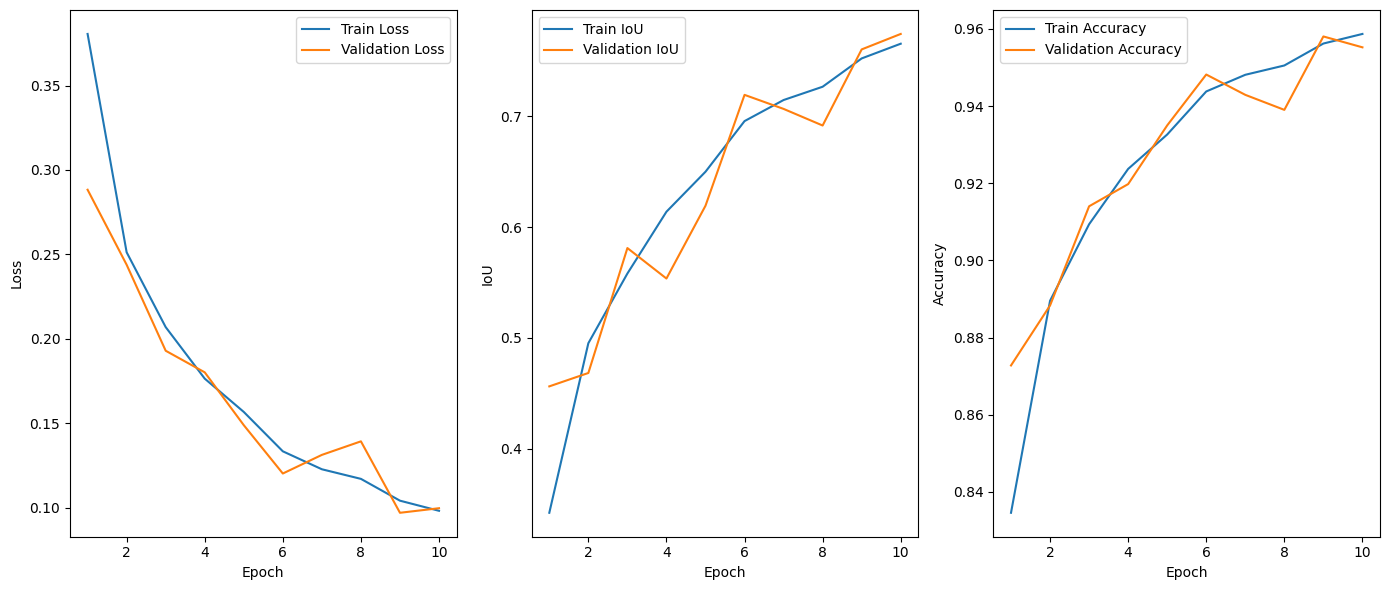

In [23]:
# plots the metrics and save it
plot_metrics(train_losses, train_ious, train_accuracies, val_losses, val_ious, val_accuracies, save_path="figures")

In [24]:
# Save the trained model
torch.save(model.state_dict(), "unet_model.pth")

## Part 5: Testing and Evaluation
- Load the trained model
- Load the test images from the test folder.
- Preprocess the test images following the same steps as the training data.
- Use the trained U-Net model to perform segmentation on the test images.
- Check your results

In [25]:
# Call the saved model
model = UNet(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("unet_model.pth"))
model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [26]:
# Define the path to the test folder
test_folder = "unet_data/test"

# Get the list of image files in the image folder
test_files = os.listdir(test_folder)

# Load and explore the first image in the image folder
first_image_path = os.path.join(test_folder, test_files[0])
first_image = Image.open(first_image_path)

review(first_image, test_files, "Test Image")

First Test Image File Name: A_1,10_ch00.tif
Test Image Format: TIFF
Test Image Mode: I;16
Test Image Size: (1024, 1024)


In [27]:
first_image = np.array(first_image)
print(first_image.shape)

(1024, 1024)


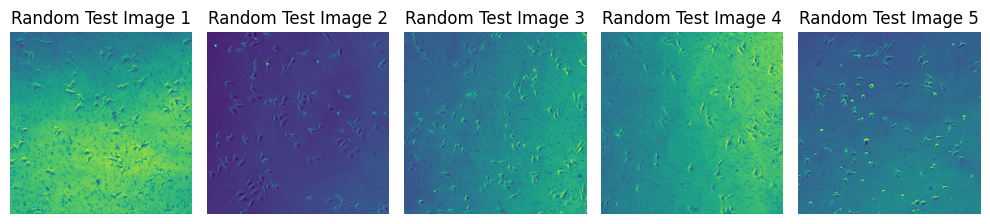

In [28]:
num_random_images = 5
visualize_random_test_images(test_folder, test_files, num_random_images, save_path="figures")

In [29]:
# Define the path to the test folder
test_folder = "unet_data/test"

# Load test images from defined path with using preprocess_test_data function from "preprocess/test"
# Then make first preprocess with resizing, and turning numpy arrays
test_images = preprocess_test_data(test_folder)

In [30]:
print(test_images.shape)
print(test_images[0].shape)

(100, 256, 256)
(256, 256)


In [31]:
check_test_data(test_images)

Data Range:
Images Min: 1172 Max: 65535

Data Types:
Images Type: uint16


In [32]:
# Do second preprocess:
# Make the images normalized to the range [0, 1], and Make the images are in float32 data type
test_images = normalize_test_data(test_images)

In [33]:
check_test_data(test_images)

Data Range:
Images Min: 0.017883575 Max: 1.0

Data Types:
Images Type: float32


In [34]:
# Convert NumPy array to PyTorch tensor
test_images_tensor = torch.from_numpy(test_images).to(device)
print(test_images_tensor.shape)

torch.Size([100, 256, 256])


In [35]:
# Predict the masks (Segmentations) of the prepared test images using the model
# To do that use predict_masks function from "model/prediction", then save them
# predicted_masks_array = predict_masks(model, test_images_tensor, threshold=0.5, device=device)
predicted_masks_array = predict_masks(model, test_images_tensor, threshold=0.5, device=device, save_folder="unet_data/predicted_masks")
print(predicted_masks_array.shape)

(100, 256, 256)


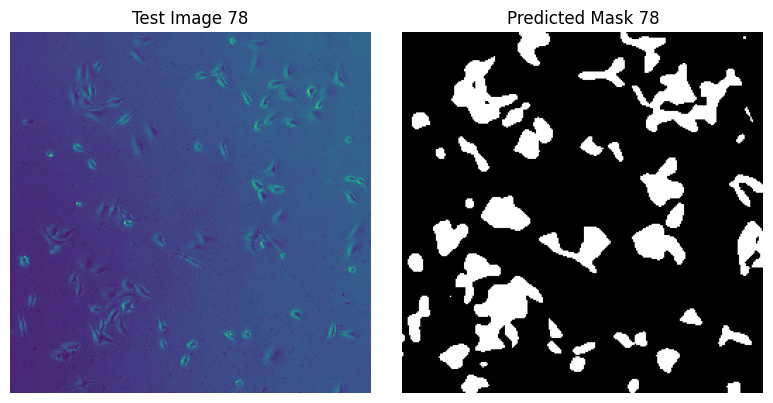

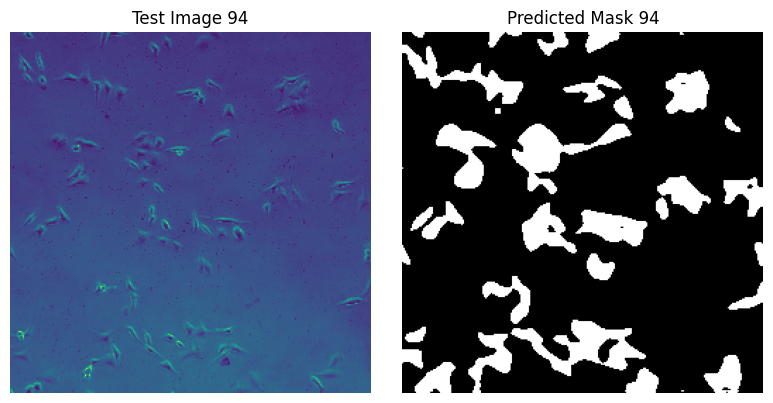

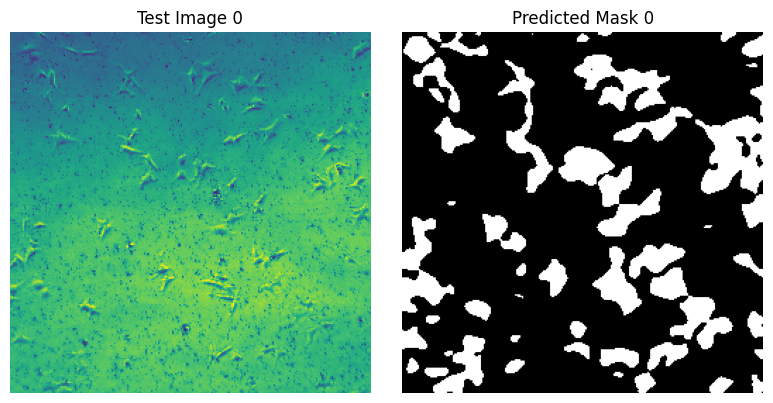

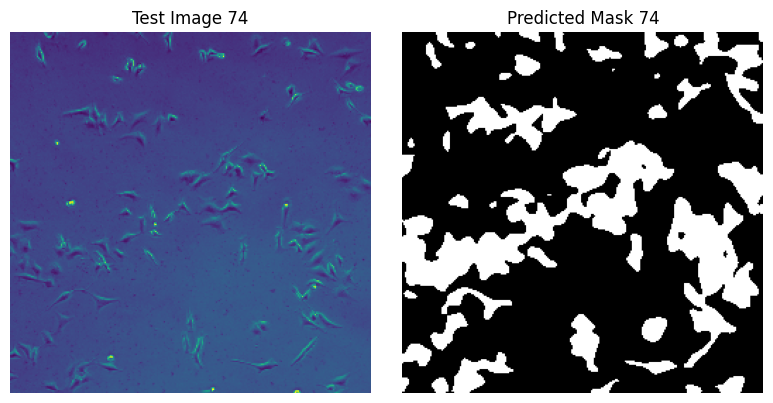

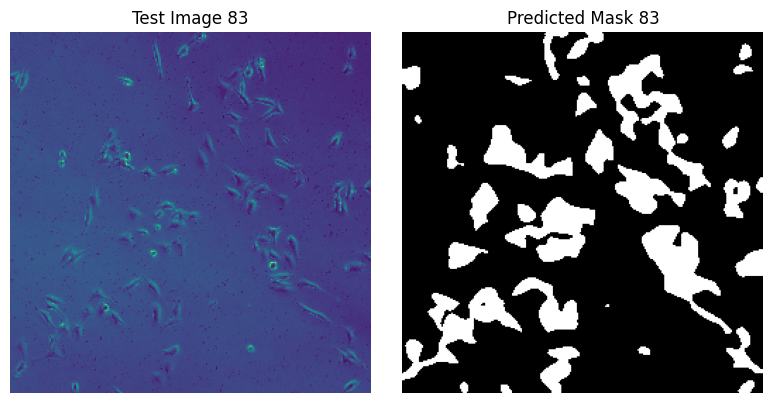

In [37]:
# plot the random predicted segmentations with corresponding test images
visualize_predicted_masks(test_images, predicted_masks_array, num_samples=5, save_path="figures")